# Thinking layers 

> No scattering makes life easier 



## Stacking cyan magenta and yellow filters 

In [ ]:
%matplotlib notebook 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.transform as skt  

foil_0 = np.zeros([1000, 1000])
foil_0[100:600, 100:600] = 1
foil_0 = skt.rotate(foil_0, 12)

foil_1 = np.zeros([1000, 1000])
foil_1[200:700, 400:900] = 1 
foil_1 =  skt.rotate(foil_1, -8)

foil_2 = np.zeros([1000, 1000])
foil_2[400:900, 250:750] = 1 
foil_2 =  skt.rotate(foil_2, 4)

foil_stack = foil_0 + foil_1 + foil_2

<IPython.core.display.Javascript object>


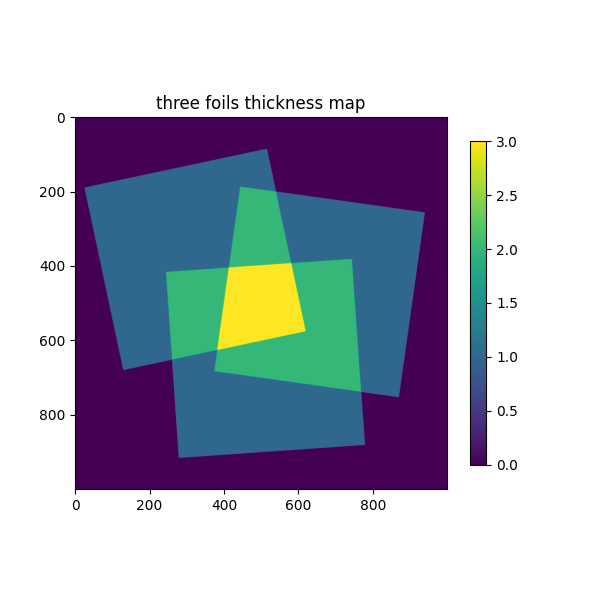

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
thickness_map = ax.imshow(foil_stack)
fig.colorbar(thickness_map, ax=ax, shrink=0.7)
ax.set_title('three foils thickness map');

In [ ]:
# absorbance values (unit thickness) for red, green and blue channel 
K_cyan = [1, 0.05, 0.07] 
K_magenta = [0.02, 1, 0.05] 
K_yellow = [0.07, 0.05, 1]

def transmission(D, K):    
    '''Calculate the RGB transmission of thickness map *D* and the RGB absorbance *K*'''
    
    # convert possible list into numpy array 
    K = np.array(K)
    
    # prepare dimensions for broadcasting multiplication  
    D = D[:,:, None]    
    K = K[None, None, :]
    
    # multiply 
    optical_density = D * K 
    
    # Lambert-Beer 
    transmission = np.exp(-optical_density)
    
    return transmission

In [ ]:
bg = np.zeros([1300, 1300])

left_stack = bg.copy()
left_stack[0:1000, 0:1000] = foil_stack 

middle_stack = bg.copy()
middle_stack[300:1300, 150:1150] = foil_stack 

right_stack = bg.copy()
right_stack[0:1000, 300:1300] = foil_stack

<IPython.core.display.Javascript object>


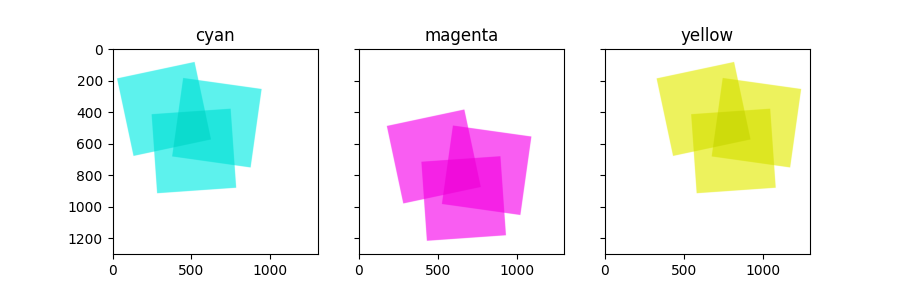

In [ ]:
T_cyan = transmission(left_stack, K_cyan)
T_magenta = transmission(middle_stack, K_magenta)
T_yellow = transmission(right_stack, K_yellow) 

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[9, 3])
ax1.imshow(T_cyan)
ax1.set_title('cyan')

ax2.imshow(T_magenta)
ax2.set_title('magenta')

ax3.imshow(T_yellow)
ax3.set_title('yellow');

Now stack the three stacks. 

In [ ]:
T_CMY = T_cyan * T_magenta * T_yellow 

<IPython.core.display.Javascript object>


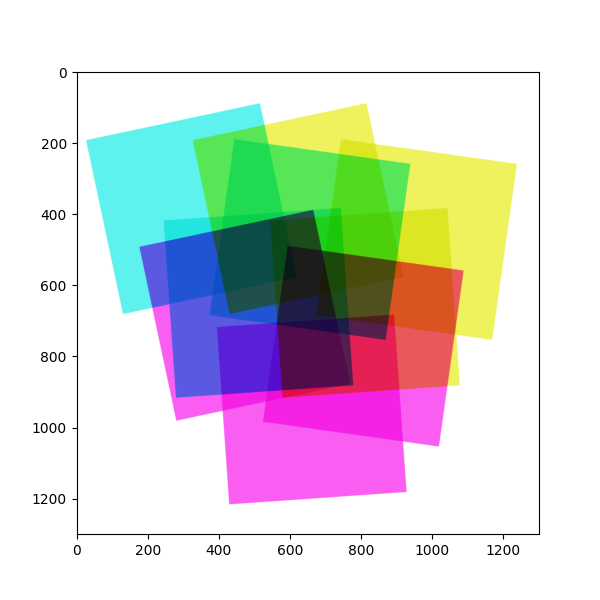

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(T_CMY);

It is easy to include an off white background. 

In [ ]:
paper = np.ones([1300, 1300, 3]) 
yellowish = np.array([0.92, 0.9, 0.85])

yellow_paper = paper * yellowish

<IPython.core.display.Javascript object>


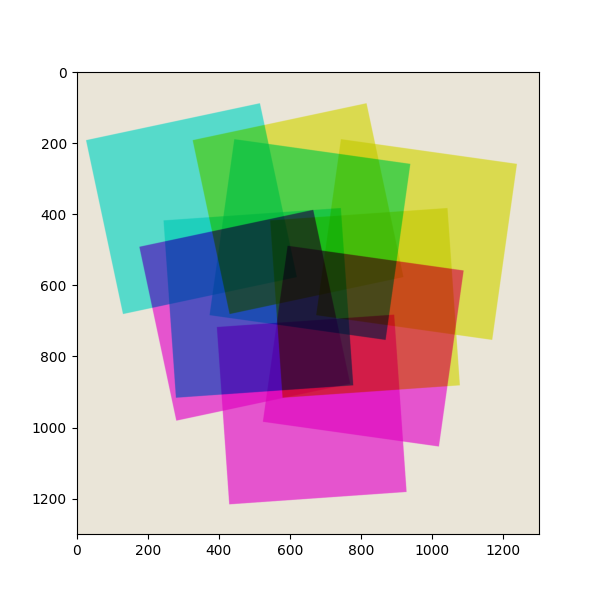

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(yellow_paper * T_CMY)

## Non Negative Matrix Factorization (NMF) 

The big question is now if we can obtain the absorbance values for the three primaries from the RGB image. 

See: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

As a first step we need to calculate the optical density for the three channels in the RGB image by taking the negative logarithm. 

In [ ]:
od_img = -np.log(T_CMY)
is_negative = od_img < 0
od_img[is_negative] = 0

In [ ]:
X = od_img.reshape([-1, 3])

In [ ]:
import numpy as np
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0, solver='mu', 
            beta_loss='kullback-leibler', max_iter=1000, tol=0.00001)

W = model.fit_transform(X)
H = model.components_

In [ ]:
H

array([[0.08125797, 0.03296822, 1.1669334 ],
       [0.0313821 , 1.56929513, 0.07845522],
       [0.67276591, 0.02094759, 0.01572713]])

In [ ]:
W_img = W.reshape(shape)

In [ ]:
W_img.shape

(1300, 1300, 3)

<IPython.core.display.Javascript object>


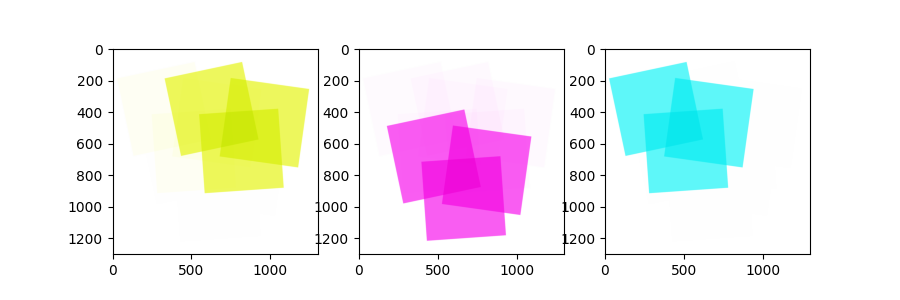

In [ ]:
fig, [ax, ax1, ax2] = plt.subplots(ncols=3, figsize=[9, 3])

ax.imshow(transmission(W_img[:,:,0], H[0]))
ax1.imshow(transmission(W_img[:,:,1], H[1]))
ax2.imshow(transmission(W_img[:,:,2], H[2]))

In [ ]:
T_CMY_fit = transmission(W_img[:,:,0], H[0]) * transmission(W_img[:,:,1], H[1]) * transmission(W_img[:,:,2], H[2])

<IPython.core.display.Javascript object>


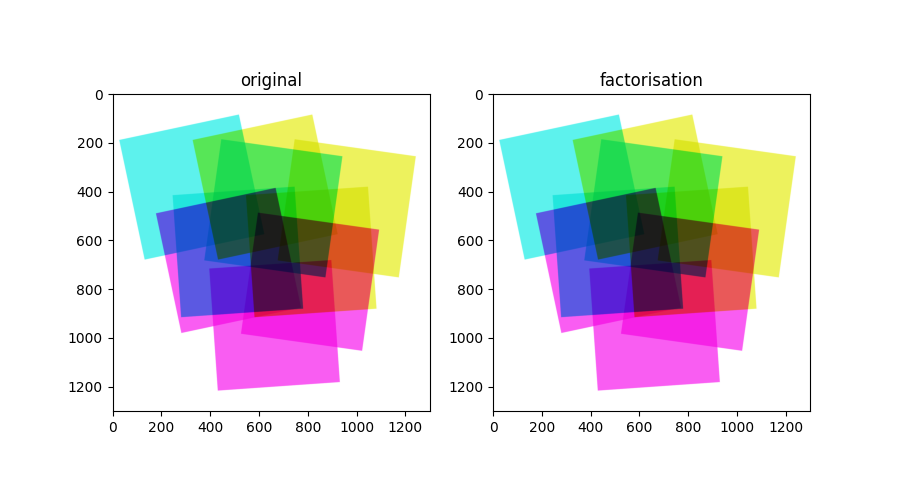

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5])

ax.imshow(T_CMY)
ax.set_title('original')
ax1.imshow(T_CMY_fit)
ax1.set_title('factorisation');